In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed2'
os.chdir(processed)
df = pd.read_csv('data.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26857 entries, 0 to 26856
Data columns (total 92 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   consumption_education                                    26857 non-null  float64
 1   income_total                                             26857 non-null  float64
 2   consumption_transportation                               26857 non-null  float64
 3   consumption_house                                        26857 non-null  float64
 4   income_salary                                            26857 non-null  float64
 5   consumption_current                                      26857 non-null  float64
 6   consumption_clothing                                     26857 non-null  float64
 7   financial_expenditures                                   26857 non-null  float64
 8   financial_income          

In [18]:
df['post'] = df['Y'] == 1996
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
df['consumption'] = df[consumption].sum(axis=1)
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df = (df.query('income > 0')
      .query('consumption > 0')
      .query('age >= 25')
      .query('age <= 60'))
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [21]:

import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

13423


In [28]:
df['education'] = pd.Categorical(df['education'], categories=['low', 'medium', 'high'])

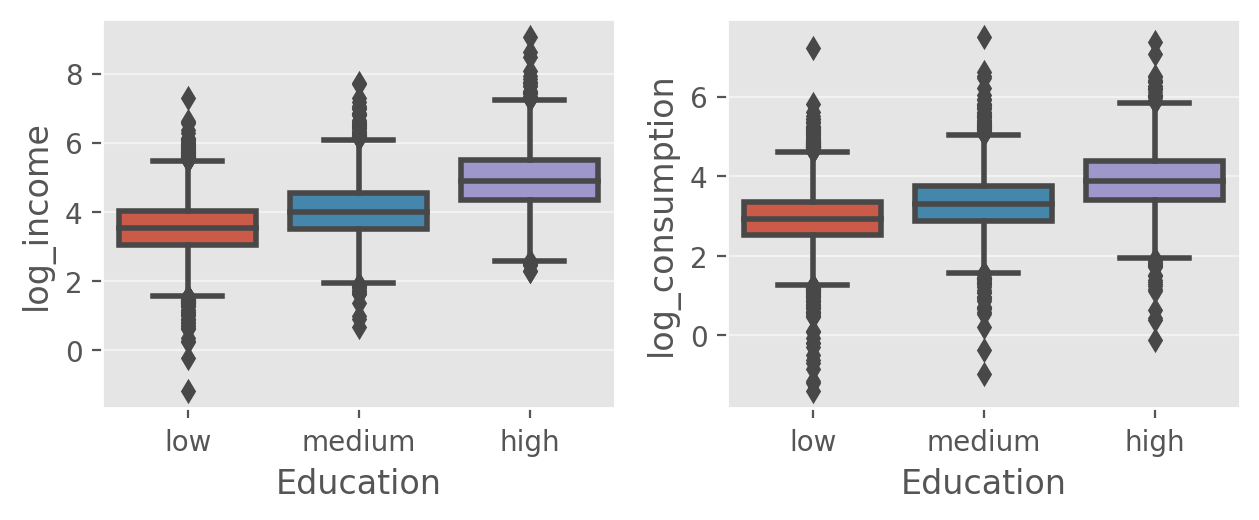

In [42]:
plt.clf()
plt.subplot(221)
sns.boxplot(df, x='education', y='log_income')
plt.xlabel('Education')

plt.subplot(222)
sns.boxplot(df, x='education', y='log_consumption')
plt.xlabel('Education')

plt.show()

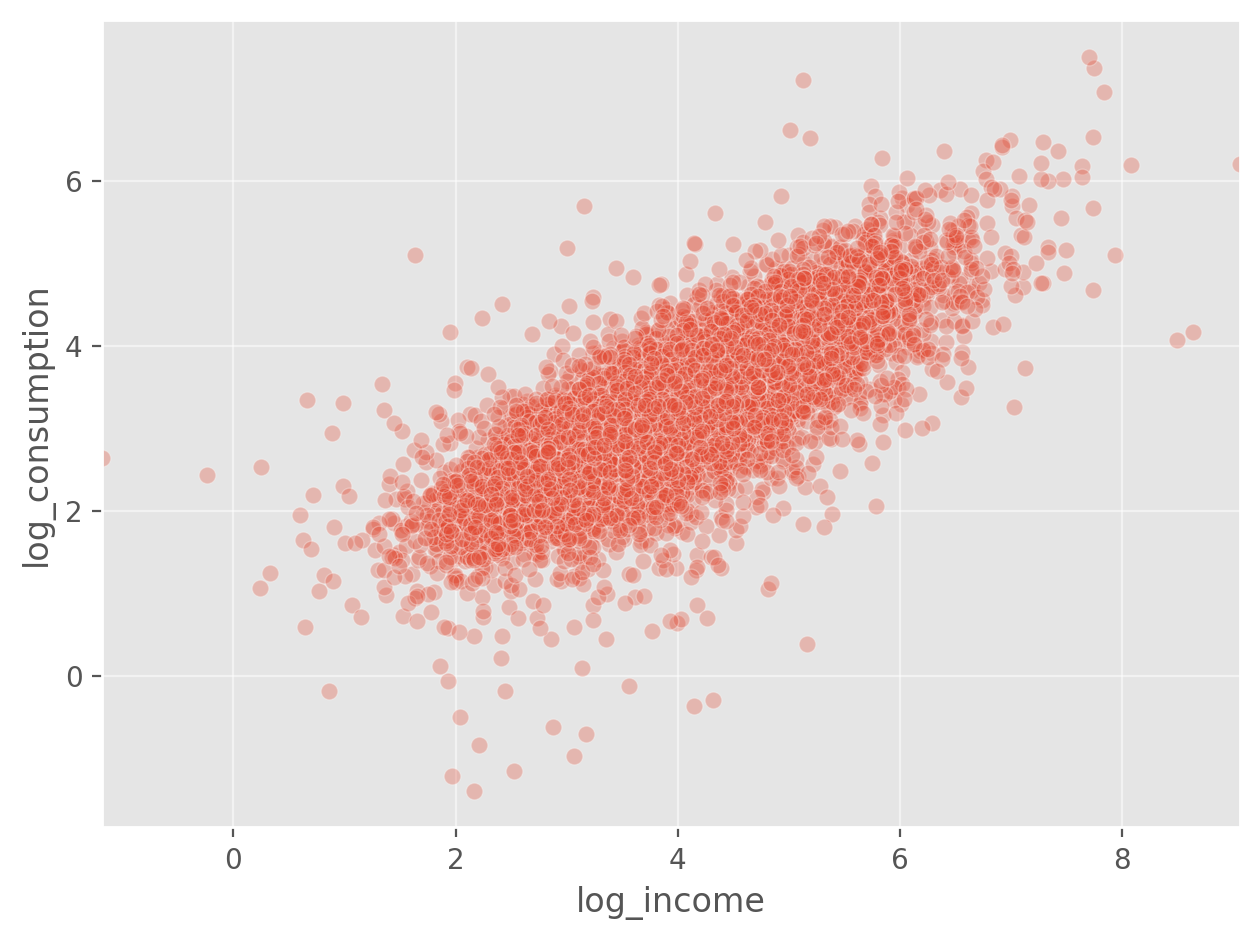

In [43]:
plt.clf()
sns.scatterplot(df, x='log_income', y='log_consumption', alpha=0.3)
plt.show()

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
linear = sm.families.Gaussian(identity())

In [36]:
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
consumption_reg = 'log_consumption ~ ' + Z + '+' + D

In [37]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [38]:
nboot = 500
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    data_boot = df.sample(len(data), weights=df['weight'], replace=True, axis=0)
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=linear).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=linear).fit()
    dincome[boot, :] = income_model.params[params]


In [39]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]

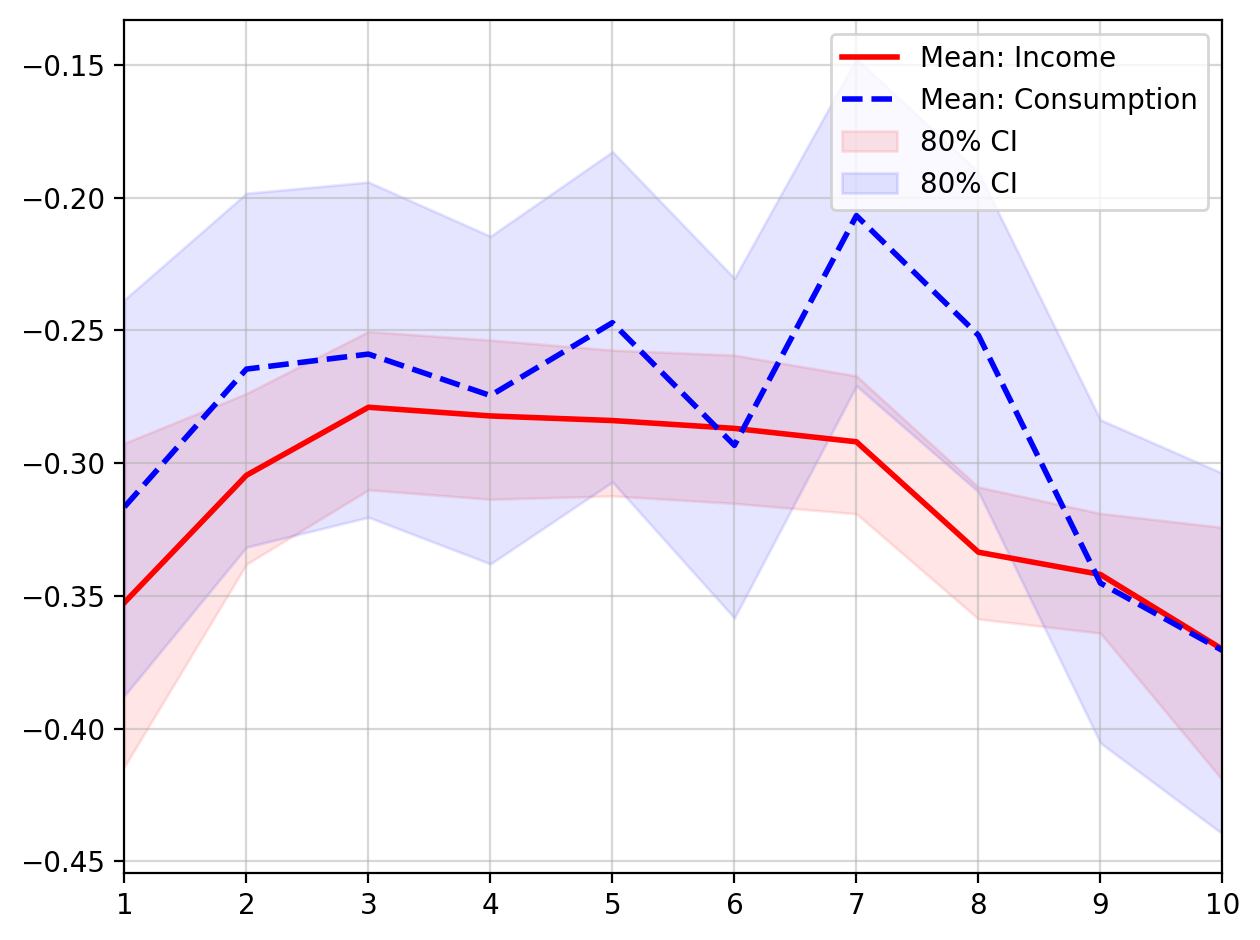

In [40]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

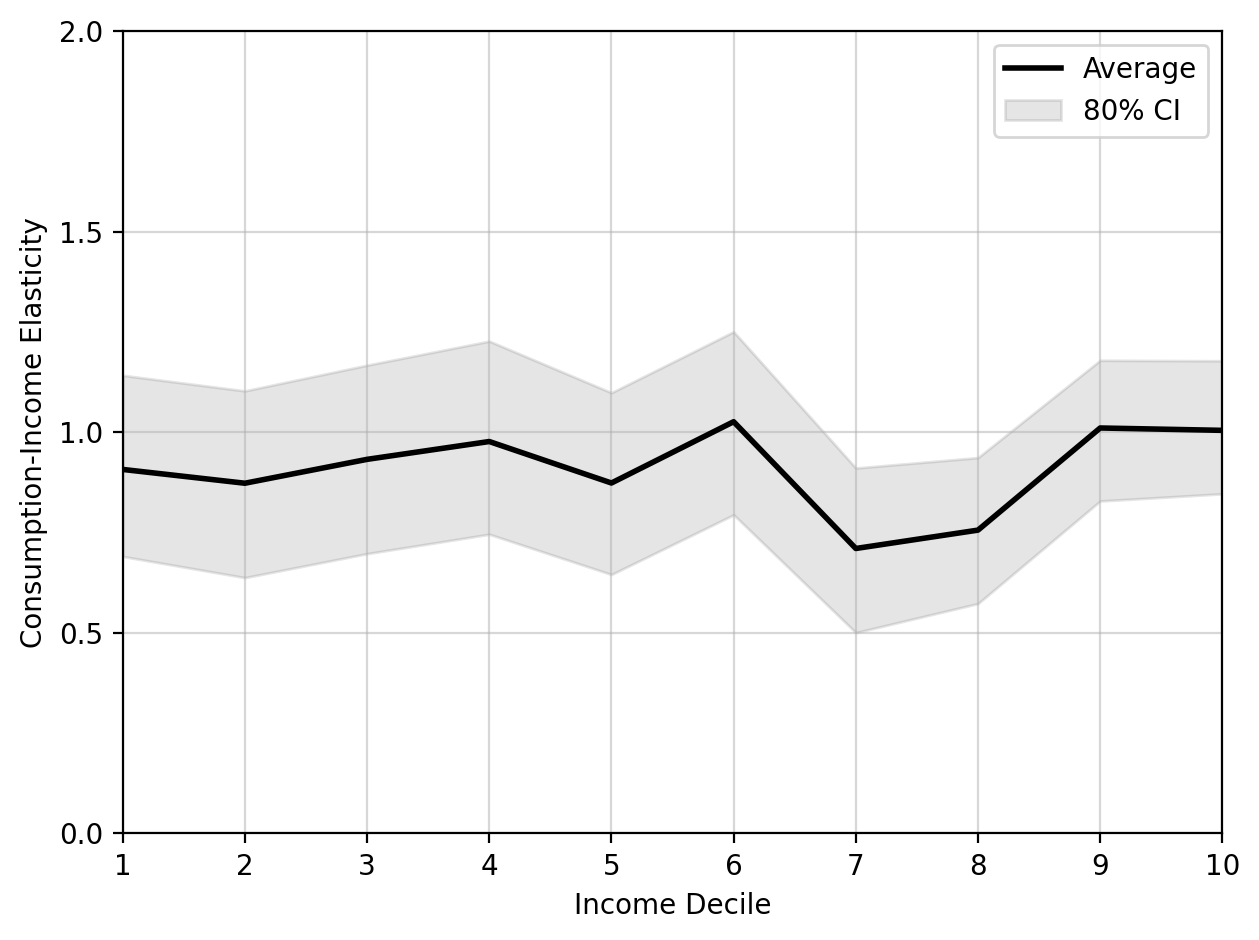

In [42]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure()

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

#if save:
    #os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)